In [6]:
# Binary Split

In [7]:
# Import and set screen proportions
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [8]:
# Upload kaggle.json to Google Collab. Get it inside the profile of your Kaggle account
from google.colab import files
files.upload()  # upload kaggle.json from your computer

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"alexbrabus","key":"d93f5e87fee4c36bfb16d52c1cf6e9e9"}'}

In [9]:
# Move kaggle.json to the right place in Google directory
!cp kaggle.json /root/.config/kaggle/
!chmod 600 /root/.config/kaggle/kaggle.json

In [10]:
#Import Titanic data from Kaggle
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('../input/titanic')
else:
    import zipfile,kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

100%|██████████| 34.1k/34.1k [00:00<00:00, 19.8MB/s]

In [11]:
#Pre-process input data

def proc_data(df):
    df['Fare'] = df.Fare.fillna(0) # You want to fill missing/corrupted Fare 0, because it will be distinct when splitting occurs,
                                  # and the algorithm will pick it up as a separate group. If you use mode for cont. variable, you'll
                                  # create an arbitrary spike, which can confuse the algorithm.
    df.fillna(modes, inplace=True) # Everything else replace missing values with mode
    df['LogFare'] = np.log1p(df['Fare']) # Still need to log Fare because it is highly right skewed
    df['Embarked'] = pd.Categorical(df.Embarked) # Marking for BinarySplit that Embarked is a category. This means its discrete and its values are limited.
    df['Sex'] = pd.Categorical(df.Sex) # Same as "Embarked".

proc_data(df)
proc_data(tst_df)

In [12]:
# Mark features based on the type of data they hold
cats=["Sex","Embarked"] # categories
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"] # continuous. WHy PClass not categorical: class 1 < 2 < 3.
                                                    # If you mark it as cat. the algorithm won't pick up that ordinal relationship
dep="Survived"

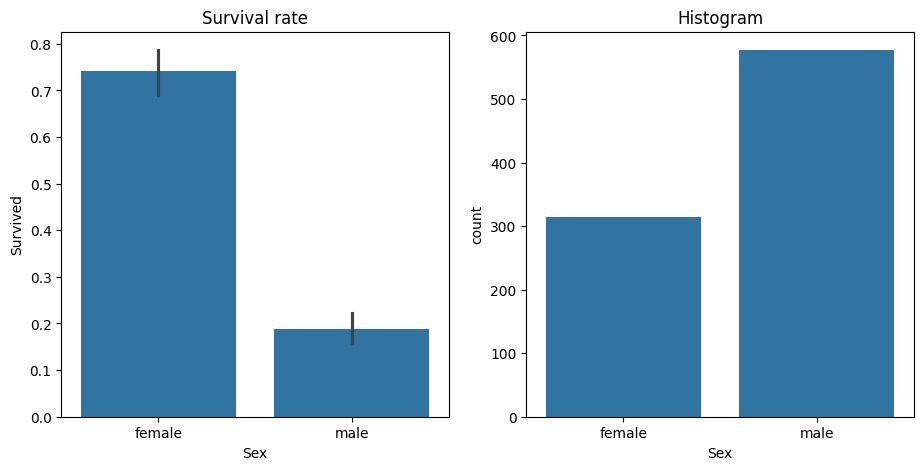

In [13]:
#Let's look at some data
import seaborn as sns

# Create a matplotlib figure with 1 row and 2 columns of subplots, sized 11x5 inches
fig,axs = plt.subplots(1,2, figsize=(11,5))

# Create a bar plot showing average survival rate (y) for each Sex category (x) in the dataset
# Place it in the first subplot and set its title
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")

# Create a count plot showing the number of passengers for each Sex category
# Place it in the second subplot and set its title
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

In [14]:
from numpy import random

# Import train_test_split function for splitting data into training and validation sets
from sklearn.model_selection import train_test_split

# Set a random seed for reproducibility so the train/validation split is always the same
random.seed(42)

# Split the dataframe 'df' into training (75%) and validation (25%) sets
trn_df, val_df = train_test_split(df, test_size=0.25)

# Convert categorical columns in the training set into integer codes (e.g., male=0, female=1)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)

# Convert categorical columns in the validation set into integer codes using the same method
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [15]:
# Define a function to extract feature matrix (X) and target vector (y) from a dataframe
def xs_y(df):
    # Create a copy of the dataframe containing only the categorical and continuous feature columns
    xs = df[cats + conts].copy()

    # Return the features (xs) and the target column (dep) if it exists in df, otherwise return None for y
    return xs, df[dep] if dep in df else None

# Extract features and target for the training set
trn_xs, trn_y = xs_y(trn_df)

# Extract features and target for the validation set
val_xs, val_y = xs_y(val_df)

In [16]:
# The prediction is just checking whether the person is female
preds = val_xs.Sex==0

In [17]:
# Calculate the error of our 'prediction' by Splitting on 'Sex'
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

0.21524663677130046

In [18]:
# Let's split on somethign else - Fare people paid

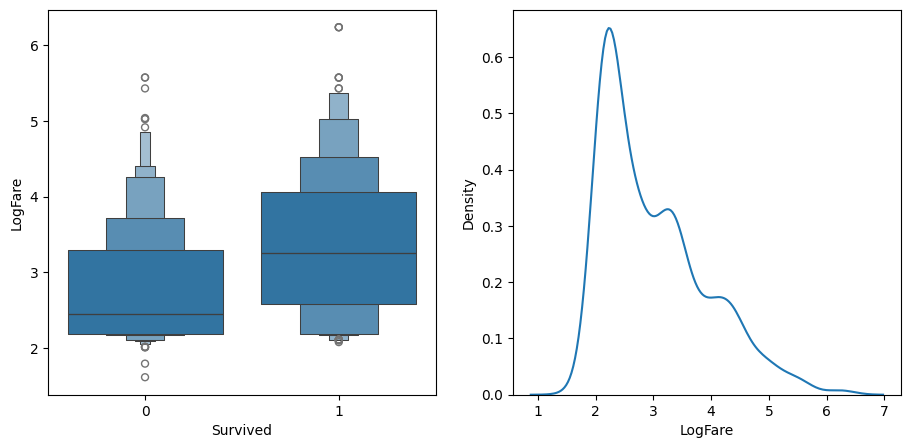

In [19]:
# Create a filtered DataFrame containing only rows where LogFare is greater than 0
df_fare = trn_df[trn_df.LogFare > 0]

# Create a matplotlib figure (fig) and an array of axes objects (axs) with 1 row and 2 columns of subplots, sized 11x5 inches
# fig = the overall container for the plots
# axs = a NumPy array of subplot "axes" where each plot will be drawn
fig, axs = plt.subplots(1, 2, figsize=(11, 5))

# Create a box plot showing the distribution of LogFare for each survival category, drawn in the first subplot
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])

# Create a KDE (Kernel Density Estimate - histogram on steroid) plot showing the smoothed distribution of LogFare, drawn in the second subplot - I didn't understand what this meant
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1]);

# this basically boils down to that most people died on the titanic
# KDE shows that most people paid fare around logfare2.2
# Most people who survived paid fare around logfare3.3

In [20]:
#splitting on fare
preds = val_xs.LogFare>2.7

In [21]:
#Let's the accuracy. Looks worse than splitting on Sex
mean_absolute_error(val_y, preds)

0.336322869955157

In [22]:
# ❓ How do we split on continuous vars (like LogFare)?
# 👉 Categorical vars (like Sex) split naturally, but continuous vars need a threshold t.
#    We try many t’s programmatically instead of eyeballing graphs.

# ❓ What’s this whole business w/ s.d. and weighting?
# 👉 For continuous vars (like LogFare), we pick a threshold t and split rows into 2 groups:
#    left = all rows where X <= t, right = all rows where X > t.
#    Then we look at y (Survived) inside each group.
# ✅ A perfect split is when one group is all y=0 and the other all y=1.
#    Standard deviation of y measures how "mixed" each group is: low = pure, high = messy.
#    We weight std by group size so that big messy groups count more than tiny pure ones.

# ❓ Why use standard deviation of y after a split?
# 👉 For binary y (0/1), std is low if the group is “pure” (all died or all survived)
#    and highest when it’s a 50/50 mix. So std is a measure of impurity.

# ❓ Why multiply std by group size (weighting)?
# 👉 Because a split that makes a tiny group perfectly pure shouldn’t fool us into
#    thinking it’s a great split if the large group is still messy. Weighting reflects
#    the impact of each group on the whole dataset.

# ❓ Why average the stds from left & right groups?
# 👉 To combine them into one overall impurity score for this candidate split. The tree
#    needs a single number to compare “split at 2.7” vs “split at 3.5” etc.

# ✅ Final intuition: A good split is one where each side of the threshold produces
#    groups of passengers whose survival outcomes are as consistent (low std) as possible,
#    especially for the larger groups.

In [23]:
# Define a helper function to score one side of a binary split
# 'side' is a boolean mask selecting the rows, 'y' is the dependent variable (target)
# Example: side = val_xs['LogFare'] > 2.7
# 0    False
# 1     True
# 2    False
# 3     True
# 4    False
# Name: LogFare, dtype: bool
def _side_score(side, y):

    # Count how many rows are in this side (number of True values in the mask)
    tot = side.sum()

    # If the side has 0 or 1 rows, it can't be split meaningfully, so return 0
    if tot <= 1: return 0

    # Otherwise, calculate the standard deviation of y in this side
    # Multiply by the group size so bigger groups have more influence on the score
    return y[side].std() * tot

In [24]:
# Define a function to calculate the impurity score of a split on one column
def score(col, y, split):

    # Create a boolean mask for the left-hand side (rows where col <= split)
    lhs = col <= split

    # Compute the total impurity score as:
    #   score of the left side + score of the right side
    # Divide by total number of rows to normalize
    return (_side_score(lhs, y) + _side_score(~lhs, y)) / len(y)


In [25]:
score(trn_xs["Sex"], trn_y, 0.5)

np.float64(0.4078753098206398)

In [26]:
score(trn_xs["LogFare"], trn_y, 2.7)

np.float64(0.4718087395209973)

In [27]:
# Define a function that calculates the impurity score for a chosen column and split value
def iscore(nm, split):
    # Select the column 'nm' from the training feature matrix
    col = trn_xs[nm]

    # Return the impurity score for this column at the given split point
    return score(col, trn_y, split)


# Import interact widget from ipywidgets (lets you create sliders/dropdowns in Jupyter)
from ipywidgets import interact

# Create an interactive widget:
# - 'nm' dropdown lets you pick from the continuous variables (conts)
# - 'split' slider lets you move the split value (default set to 15.5)
# Whenever you change them, 'iscore' is called and the score is printed
interact(nm=conts, split=15.5)(iscore);


interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

In [28]:
# Let's try to automatically find the best split value for column "Age"
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()] # returns the index of the smallest value in an array

np.float64(6.0)

In [29]:
#Here's the same thing in function form
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Age")

(np.float64(6.0), np.float64(0.47831671750899085))

In [30]:
#Do the same for every column
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (np.int8(0), np.float64(0.4078753098206398)),
 'Embarked': (np.int8(0), np.float64(0.478833425731479)),
 'Age': (np.float64(6.0), np.float64(0.47831671750899085)),
 'SibSp': (np.int64(4), np.float64(0.4783740258817423)),
 'Parch': (np.int64(0), np.float64(0.4805296527841601)),
 'LogFare': (np.float64(2.4390808375825834), np.float64(0.4620823937736595)),
 'Pclass': (np.int64(2), np.float64(0.4604826188580666))}

In [31]:
# This is called a R1 classifier

In [32]:
# Decision Tree
# The idea is simple - once you've found the best split on the data (in oru case its Sex)
# find the next best split for each of the values - Female and Male.

#Get only female rows; get only male rows
cols.remove("Sex")
ismale = trn_df.Sex==1
males,females = trn_df[ismale],trn_df[~ismale]

In [33]:
# Find the best split for males
{o:min_col(males, o) for o in cols}

{'Embarked': (np.int8(0), np.float64(0.387558187041091)),
 'Age': (np.float64(6.0), np.float64(0.37398283710105873)),
 'SibSp': (np.int64(4), np.float64(0.38758642275862637)),
 'Parch': (np.int64(0), np.float64(0.3874704821461953)),
 'LogFare': (np.float64(2.803360380906535), np.float64(0.38048562317581447)),
 'Pclass': (np.int64(1), np.float64(0.3815544200436083))}

In [34]:
# Find the best split for females
{o:min_col(females, o) for o in cols}

{'Embarked': (np.int8(0), np.float64(0.4295252982857326)),
 'Age': (np.float64(50.0), np.float64(0.4225927658431646)),
 'SibSp': (np.int64(4), np.float64(0.42319212059713585)),
 'Parch': (np.int64(3), np.float64(0.4193314500446157)),
 'LogFare': (np.float64(4.256321678298823), np.float64(0.413505983329114)),
 'Pclass': (np.int64(2), np.float64(0.3335388911567602))}

In [35]:
# We've just created a tree. 1st check Sex. If female, check Pclass <=2
# If male, check Age <= 6. But this is all done manually. We need an automatic way to do it.
# Enter DecisionTreeClassifier

In [36]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [37]:
# To draw the result
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

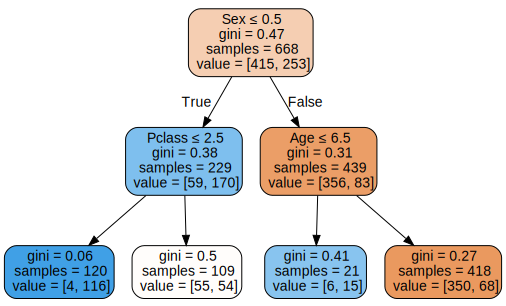

In [38]:
draw_tree(m, trn_xs)

In [39]:
# another way to caluclate impurity is using gini
def gini(cond):
    act = df.loc[cond, dep]
    return 1 - act.mean()**2 - (1-act).mean()**2

In [40]:
# How accurate is this decision tree?
mean_absolute_error(val_y, m.predict(val_xs))
# turns out a bit worse than what we predicted if we just split on Sex, which was .215

0.2242152466367713

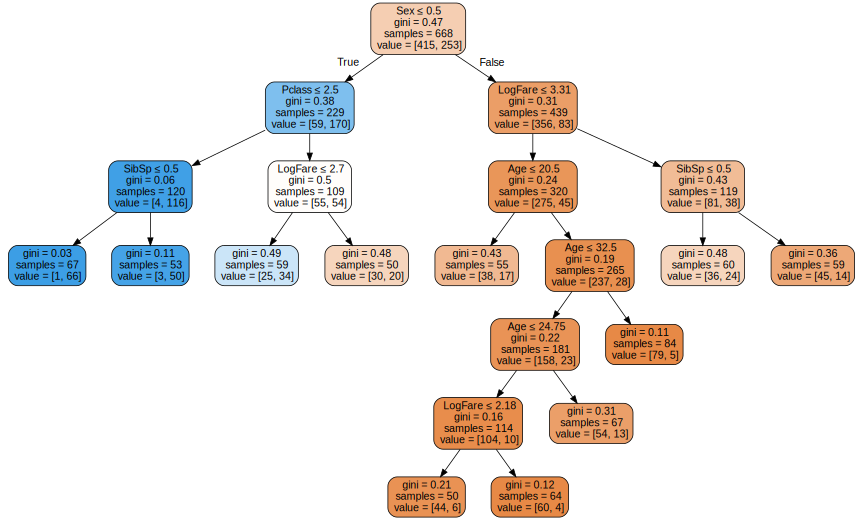

In [41]:
#Lets try a bigger decision tree
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(trn_xs, trn_y)
draw_tree(m, trn_xs, size=12)

In [42]:
#looks like an improvement
mean_absolute_error(val_y, m.predict(val_xs))

0.18385650224215247

In [ ]:
# random forests - a bunch of randomly generated trees averaged out
# this is a fix to just doing one deep tree, because with little data at the bottom
# its predictions arent very good
# but if you make a lot of such deep 'noisy' trees and average them out - you get good preds.

In [45]:
def get_tree(prop=0.75):
    # Define a function that trains a decision tree on a random subset of the data.
    # 'prop' is the proportion of the dataset to use (default = 75%).

    n = len(trn_y)
    # Get the total number of training samples.

    idxs = random.choice(n, int(n*prop))
    # Randomly choose 'prop' fraction of the dataset indices (with replacement).
    # This creates the bootstrap sample used to train one tree.
    # e.g. random.choice(10, int(10*0.75)) => array([5, 1, 7, 7, 0, 2, 9])

    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])
    # Create a Decision Tree classifier with a minimum of 5 samples per leaf.
    # Fit (train) this tree on the randomly chosen subset of training data.
    # Return the trained tree.


In [46]:
# Lets try it manually
trees = [get_tree() for t in range(100)]
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)
mean_absolute_error(val_y, avg_probs)

0.22730941704035873

In [ ]:
# In a Random Forest, there are TWO types of randomness that make the trees diverse:
#
# 1. Random rows (data samples) = "bagging"
#    - For each tree, we pick a random subset of the rows (observations), with replacement.
#     "With replacement" means when we randomly sample rows for each tree,
#     we allow the same row to be picked more than once.
#     So some rows may be duplicated in the sample, while others are left out.
#     This bootstrap sampling makes each tree see a slightly different version
#     of the dataset, reducing correlation between trees.
#    - Example: if we have 10,000 rows, one tree may only see ~7,500 randomly chosen rows.
#    - This reduces variance since each tree trains on different data.
#
# 2. Random columns (features)
#    - At each split in the tree, the algorithm looks at only a random subset of the features.
#    - Example: if there are 10 features, a given split might only consider 3 of them.
#    - This prevents the same "strong" feature (e.g. Sex=female in Titanic) from dominating every tree.
#    - This increases diversity, since trees use different "perspectives" of the data.
#
# 🔑 Why both?
# - Random rows = each tree sees different examples
# - Random columns = each tree uses different subsets of features
# - Together, this makes trees less correlated → averaging their predictions cancels out errors.


In [47]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
# Create a random forest with 100 decision trees,
# each tree must have at least 5 samples in every leaf node
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.18834080717488788

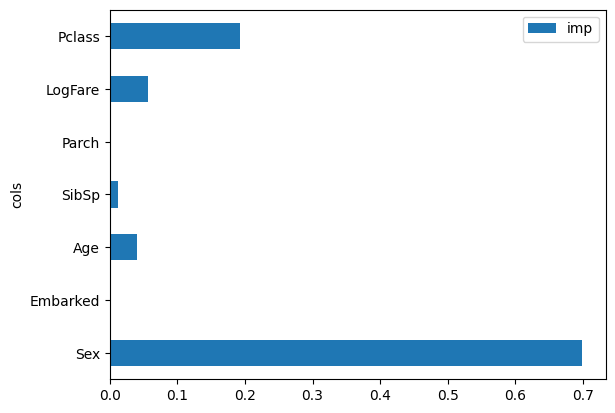

In [48]:
# This shows which columns have the most effect on the outcome.
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');